# Fluzz — Détection de fraude bancaire  
**Partie 2 — Comparatif des modèles (Module 2)**

Ce notebook compare 3 algorithmes d'apprentissage automatique pour la détection de fraude bancaire :
- **Régression Logistique** : modèle linéaire simple et interprétable
- **Random Forest** : ensemble d'arbres de décision
- **MLP** (Multi-Layer Perceptron) : réseau de neurones

**Métriques d'évaluation** : F1-Score, Précision, Rappel (adaptées aux classes déséquilibrées)

## 1. Chargement des données et préparation

In [1]:
# Suppression complète des warnings pour un notebook propre
import warnings
import os
import sys

# Suppression de tous les types de warnings
warnings.filterwarnings('ignore')
os.environ['PYTHONWARNINGS'] = 'ignore'

# Suppression des warnings spécifiques à sklearn et numpy
warnings.filterwarnings('ignore', category=RuntimeWarning)
warnings.filterwarnings('ignore', category=UserWarning)
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', module='sklearn')
warnings.filterwarnings('ignore', module='numpy')

print("Configuration des warnings : ✓ Tous les warnings sont supprimés")

Configuration des warnings : ✓ Tous les warnings sont supprimés


In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, confusion_matrix, f1_score, precision_score, recall_score
from sklearn.metrics import precision_recall_curve, average_precision_score, make_scorer
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os

# Suppression complète des warnings
warnings.filterwarnings('ignore')
os.environ['PYTHONWARNINGS'] = 'ignore'

# Chargement des données
df = pd.read_csv('../01_data/creditcard.csv')
print(f"Dataset chargé : {df.shape[0]} transactions, {df.shape[1]} features")
print(f"Taux de fraude : {df['Class'].mean()*100:.3f}%")

Dataset chargé : 284807 transactions, 31 features
Taux de fraude : 0.173%


In [3]:
# Séparation des features et de la cible
X = df.drop('Class', axis=1)
y = df['Class']

# Division train/test (70/30)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

print(f"Jeu d'entraînement : {X_train.shape[0]} échantillons")
print(f"Jeu de test : {X_test.shape[0]} échantillons")
print(f"Fraudes dans le test : {y_test.sum()} ({y_test.mean()*100:.3f}%)")

Jeu d'entraînement : 199364 échantillons
Jeu de test : 85443 échantillons
Fraudes dans le test : 148 (0.173%)


In [4]:
# Normalisation des données (nécessaire pour MLP et Régression Logistique)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Données normalisées avec succès")

Données normalisées avec succès


## 2. Entraînement des modèles de base

In [5]:
# Configuration des pipelines avec gestion du déséquilibre
from sklearn.pipeline import Pipeline

# Création des pipelines - preprocessing intégré
pipelines = {
    'Régression Logistique': Pipeline([
        ('scaler', StandardScaler()),
        ('classifier', LogisticRegression(
            class_weight='balanced',
            random_state=42,
            max_iter=1000
        ))
    ]),
    'Random Forest': Pipeline([
        ('classifier', RandomForestClassifier(
            class_weight='balanced',
            random_state=42,
            n_estimators=100
        ))
    ]),  # Pas de scaling pour Random Forest
    'MLP': Pipeline([
        ('scaler', StandardScaler()),
        ('classifier', MLPClassifier(
            hidden_layer_sizes=(100, 50),
            random_state=42,
            max_iter=500,
            early_stopping=True
        ))
    ])
}

print("Pipelines configurés :")
for name, pipeline in pipelines.items():
    print(f"• {name}: {[step[0] for step in pipeline.steps]}")

print("\nAvantages des pipelines :")
print("  • Prévention du data leakage (scaling par fold)")
print("  • Code plus propre et reproductible")
print("  • Preprocessing automatique cohérent")

Pipelines configurés :
• Régression Logistique: ['scaler', 'classifier']
• Random Forest: ['classifier']
• MLP: ['scaler', 'classifier']

Avantages des pipelines :
  • Prévention du data leakage (scaling par fold)
  • Code plus propre et reproductible
  • Preprocessing automatique cohérent


In [6]:
# Entraînement des pipelines sur données non-normalisées
trained_pipelines = {}

print("Début de l'entraînement des pipelines...\n")

for name, pipeline in pipelines.items():
    print(f"Entraînement de {name}...")
    
    # Pipelines s'occupent automatiquement du preprocessing
    pipeline.fit(X_train, y_train)
    
    trained_pipelines[name] = pipeline
    print(f"✓ {name} entraîné (pipeline complet)")

print("\nTous les pipelines sont entraînés !")
print("Le preprocessing (scaling) est maintenant intégré et automatique")

Début de l'entraînement des pipelines...

Entraînement de Régression Logistique...
✓ Régression Logistique entraîné (pipeline complet)
Entraînement de Random Forest...
✓ Random Forest entraîné (pipeline complet)
Entraînement de MLP...
✓ MLP entraîné (pipeline complet)

Tous les pipelines sont entraînés !
Le preprocessing (scaling) est maintenant intégré et automatique


## 2.1. Évaluation des modèles de base sur le jeu de test

Avant l'optimisation, évaluons les performances des modèles de base avec leurs paramètres par défaut.

In [7]:
# Évaluation des modèles de base (non-optimisés) sur le jeu de test
baseline_results = []

print("ÉVALUATION DES MODÈLES DE BASE (NON-OPTIMISÉS)")
print("=" * 50)

for name, pipeline in trained_pipelines.items():
    print(f"\n=== {name} (Modèle de base) ===")
    
    # Prédictions avec pipelines - preprocessing automatique
    y_pred = pipeline.predict(X_test)
    y_pred_proba = pipeline.predict_proba(X_test)[:, 1]
    
    # Calcul des métriques avec seuil par défaut (0.5)
    f1 = f1_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    pr_auc = average_precision_score(y_test, y_pred_proba)
    
    baseline_results.append({
        'Modèle': name + ' (Base)',
        'F1-Score': f1,
        'Précision': precision,
        'Rappel': recall,
        'PR-AUC': pr_auc
    })
    
    print(f"F1-Score : {f1:.4f}")
    print(f"Précision : {precision:.4f}")
    print(f"Rappel : {recall:.4f}")
    print(f"PR-AUC : {pr_auc:.4f}")

# Création du DataFrame des résultats de base
baseline_results_df = pd.DataFrame(baseline_results)
print("\n" + "="*60)
print("RÉSUMÉ DES PERFORMANCES - MODÈLES DE BASE")
print("="*60)
print(baseline_results_df.round(4))
print("\nCes résultats serviront de référence pour mesurer l'impact de l'optimisation")

ÉVALUATION DES MODÈLES DE BASE (NON-OPTIMISÉS)

=== Régression Logistique (Modèle de base) ===
F1-Score : 0.1247
Précision : 0.0671
Rappel : 0.8784
PR-AUC : 0.7050

=== Random Forest (Modèle de base) ===
F1-Score : 0.8157
Précision : 0.9720
Rappel : 0.7027
PR-AUC : 0.8059

=== MLP (Modèle de base) ===
F1-Score : 0.8000
Précision : 0.9060
Rappel : 0.7162
PR-AUC : 0.7893

RÉSUMÉ DES PERFORMANCES - MODÈLES DE BASE
                         Modèle  F1-Score  Précision  Rappel  PR-AUC
0  Régression Logistique (Base)    0.1247     0.0671  0.8784  0.7050
1          Random Forest (Base)    0.8157     0.9720  0.7027  0.8059
2                    MLP (Base)    0.8000     0.9060  0.7162  0.7893

Ces résultats serviront de référence pour mesurer l'impact de l'optimisation


## 2.2. Augmentation des données avec SDV

Pour améliorer les performances sur ce dataset très déséquilibré (0.173% de fraudes), nous allons utiliser **SDV (Synthetic Data Vault)** pour générer des transactions frauduleuses synthétiques.

In [8]:
# Import SDV pour la génération de données synthétiques
try:
    from sdv.single_table import GaussianCopulaSynthesizer
    from sdv.metadata import SingleTableMetadata
    SDV_AVAILABLE = True
    print("✓ SDV importé avec succès")
except ImportError:
    SDV_AVAILABLE = False
    print("⚠️ SDV non disponible - installation requise: pip install sdv")
    print("Continuons sans augmentation de données...")

# Séparation des classes pour l'augmentation
df_fraud_only = df[df['Class'] == 1].copy()
df_legit_only = df[df['Class'] == 0].copy()

print(f"Transactions frauduleuses : {len(df_fraud_only)}")
print(f"Transactions légitimes : {len(df_legit_only)}")
print(f"Ratio de déséquilibre : 1:{len(df_legit_only)//len(df_fraud_only)}")

✓ SDV importé avec succès
Transactions frauduleuses : 492
Transactions légitimes : 284315
Ratio de déséquilibre : 1:577


In [9]:
# Génération de données synthétiques avec SDV
if SDV_AVAILABLE:
    print("Configuration du modèle SDV pour générer des fraudes synthétiques...")
    
    # Configuration des métadonnées
    metadata = SingleTableMetadata()
    metadata.detect_from_dataframe(df_fraud_only)
    
    # Configuration du synthesizer pour données numériques
    synthesizer = GaussianCopulaSynthesizer(
        metadata=metadata,
        default_distribution='gaussian_kde',
        numerical_distributions={
            'Amount': 'gamma'  # Distribution appropriée pour les montants
        }
    )
    
    # Entraînement du modèle SDV
    print("Entraînement du modèle SDV sur les fraudes existantes...")
    synthesizer.fit(df_fraud_only)
    
    # Stratégie d'augmentation : générer 1000 fraudes synthétiques (test rapide)
    num_synthetic_fraud = 1000
    
    print(f"Génération de {num_synthetic_fraud} transactions frauduleuses synthétiques...")
    synthetic_fraud = synthesizer.sample(num_rows=num_synthetic_fraud)
    
    # Création du dataset augmenté
    df_augmented = pd.concat([
        df,  # Dataset original
        synthetic_fraud  # Fraudes synthétiques
    ], ignore_index=True)
    
    print(f"✓ Dataset augmenté créé : {df_augmented.shape[0]} transactions")
    print(f"Nouveau taux de fraude : {df_augmented['Class'].mean()*100:.4f}%")
    
    # Division du dataset augmenté
    X_aug = df_augmented.drop('Class', axis=1)
    y_aug = df_augmented['Class']
    X_train_aug, X_test_aug, y_train_aug, y_test_aug = train_test_split(
        X_aug, y_aug, test_size=0.3, random_state=42, stratify=y_aug
    )
    
    print(f"Jeu d'entraînement augmenté : {X_train_aug.shape[0]} échantillons")
    print(f"Fraudes dans l'entraînement augmenté : {y_train_aug.sum()} ({y_train_aug.mean()*100:.3f}%)")
    
else:
    print("SDV non disponible - pas d'augmentation de données")
    df_augmented = df.copy()
    X_train_aug, X_test_aug, y_train_aug, y_test_aug = X_train, X_test, y_train, y_test

Configuration du modèle SDV pour générer des fraudes synthétiques...
Entraînement du modèle SDV sur les fraudes existantes...
Génération de 1000 transactions frauduleuses synthétiques...
✓ Dataset augmenté créé : 285807 transactions
Nouveau taux de fraude : 0.5220%
Jeu d'entraînement augmenté : 200064 échantillons
Fraudes dans l'entraînement augmenté : 1044 (0.522%)


## 2.3. Entraînement des modèles avec données augmentées

Maintenant, entraînons les mêmes pipelines sur le dataset augmenté pour voir l'impact de SDV.

In [10]:
# Entraînement des pipelines sur données augmentées
if SDV_AVAILABLE:
    trained_pipelines_aug = {}
    
    print("Entraînement des modèles sur le dataset augmenté...")
    print("=" * 50)
    
    for name, pipeline in pipelines.items():
        print(f"Entraînement de {name} sur données augmentées...")
        
        # Clone du pipeline pour éviter les conflits
        from sklearn.base import clone
        pipeline_aug = clone(pipeline)
        
        # Entraînement sur données augmentées
        pipeline_aug.fit(X_train_aug, y_train_aug)
        trained_pipelines_aug[name] = pipeline_aug
        
        print(f"✓ {name} entraîné sur {X_train_aug.shape[0]} échantillons augmentés")
    
    print(f"\nTous les modèles entraînés sur dataset augmenté !")
    print(f"Impact de l'augmentation : {y_train_aug.mean()*100:.3f}% de fraudes vs {y_train.mean()*100:.3f}% original")
    
else:
    print("Pas d'augmentation SDV - utilisation des modèles originaux")
    trained_pipelines_aug = trained_pipelines.copy()

Entraînement des modèles sur le dataset augmenté...
Entraînement de Régression Logistique sur données augmentées...
✓ Régression Logistique entraîné sur 200064 échantillons augmentés
Entraînement de Random Forest sur données augmentées...
✓ Random Forest entraîné sur 200064 échantillons augmentés
Entraînement de MLP sur données augmentées...
✓ MLP entraîné sur 200064 échantillons augmentés

Tous les modèles entraînés sur dataset augmenté !
Impact de l'augmentation : 0.522% de fraudes vs 0.173% original


In [11]:
# Évaluation des modèles entraînés avec données augmentées
if SDV_AVAILABLE:
    augmented_results = []
    
    print("ÉVALUATION DES MODÈLES AVEC DONNÉES AUGMENTÉES SDV")
    print("=" * 60)
    print("⚠️ IMPORTANT: Test sur données RÉELLES uniquement (pas de synthétiques)")
    
    for name, pipeline in trained_pipelines_aug.items():
        print(f"\n=== {name} (Avec augmentation SDV) ===")
        
        # Test sur les données réelles originales uniquement
        y_pred = pipeline.predict(X_test)
        y_pred_proba = pipeline.predict_proba(X_test)[:, 1]
        
        # Calcul des métriques
        f1 = f1_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        pr_auc = average_precision_score(y_test, y_pred_proba)
        
        augmented_results.append({
            'Modèle': name + ' (SDV)',
            'F1-Score': f1,
            'Précision': precision,
            'Rappel': recall,
            'PR-AUC': pr_auc
        })
        
        print(f"F1-Score : {f1:.4f}")
        print(f"Précision : {precision:.4f}")
        print(f"Rappel : {recall:.4f}")
        print(f"PR-AUC : {pr_auc:.4f}")
    
    # DataFrame des résultats avec SDV
    augmented_results_df = pd.DataFrame(augmented_results)
    print("\n" + "="*60)
    print("RÉSUMÉ - MODÈLES AVEC AUGMENTATION SDV")
    print("="*60)
    print(augmented_results_df.round(4))
    
else:
    print("Pas d'augmentation SDV - évaluation non nécessaire")
    augmented_results = []

ÉVALUATION DES MODÈLES AVEC DONNÉES AUGMENTÉES SDV
⚠️ IMPORTANT: Test sur données RÉELLES uniquement (pas de synthétiques)

=== Régression Logistique (Avec augmentation SDV) ===
F1-Score : 0.1101
Précision : 0.0587
Rappel : 0.8851
PR-AUC : 0.5321

=== Random Forest (Avec augmentation SDV) ===
F1-Score : 0.9236
Précision : 0.9500
Rappel : 0.8986
PR-AUC : 0.9203

=== MLP (Avec augmentation SDV) ===
F1-Score : 0.8176
Précision : 0.8176
Rappel : 0.8176
PR-AUC : 0.8421

RÉSUMÉ - MODÈLES AVEC AUGMENTATION SDV
                        Modèle  F1-Score  Précision  Rappel  PR-AUC
0  Régression Logistique (SDV)    0.1101     0.0587  0.8851  0.5321
1          Random Forest (SDV)    0.9236     0.9500  0.8986  0.9203
2                    MLP (SDV)    0.8176     0.8176  0.8176  0.8421


## 3. Optimisation des hyperparamètres avec GridSearchCV

L'optimisation des hyperparamètres permet d'améliorer les performances des modèles en trouvant la meilleure combinaison de paramètres. Nous utilisons **GridSearchCV** avec validation croisée stratifiée pour une évaluation robuste.

In [12]:
from sklearn.model_selection import GridSearchCV

# Configuration des grilles d'hyperparamètres pour pipelines (préfixe classifier__)
param_grids_pipeline = {
    'Régression Logistique': {
        'classifier__C': [0.1, 1.0, 10.0],
        'classifier__penalty': ['l2'],  # Utilisation uniquement de L2 pour plus de stabilité
        'classifier__solver': ['lbfgs']  # Solver plus robuste pour L2
    },
    'Random Forest': {
        'classifier__n_estimators': [50, 100, 200],
        'classifier__max_depth': [10, 20, None],
        'classifier__min_samples_leaf': [1, 2, 4]
    },
    'MLP': {
        'classifier__hidden_layer_sizes': [(50,), (100,), (100, 50)],
        'classifier__alpha': [0.001, 0.01, 0.1],
        'classifier__learning_rate_init': [0.001, 0.01]
    }
}

print("Grilles d'hyperparamètres configurées pour pipelines :")
for model_name, params in param_grids_pipeline.items():
    print(f"\n{model_name}:")
    for param, values in params.items():
        print(f"  • {param}: {values}")

# Configuration EXPLICITE du StratifiedKFold pour GridSearchCV (crucial pour classes déséquilibrées)
cv_stratified_3fold = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# Configuration du scorer pour l'optimisation (F1-Score plus stable que PR-AUC)
scorer = make_scorer(f1_score)

print(f"\nIMPORTANT : Classes déséquilibrées détectées ({y.mean()*100:.3f}% de fraudes)")
print(f"Métrique d'optimisation : F1-Score (plus stable que PR-AUC pour GridSearchCV)")
print(f"Validation croisée : StratifiedKFold 3-fold (préserve la proportion des classes)")
print(f"   • Chaque fold contient ~{y.mean()*100:.3f}% de fraudes")
print(f"   • Évite les folds sans fraudes (problème avec KFold classique)")
print(f"Pipelines : Preprocessing (scaling) appliqué automatiquement à chaque fold")
print(f"Note : PR-AUC sera calculé séparément pour l'évaluation finale")

Grilles d'hyperparamètres configurées pour pipelines :

Régression Logistique:
  • classifier__C: [0.1, 1.0, 10.0]
  • classifier__penalty: ['l2']
  • classifier__solver: ['lbfgs']

Random Forest:
  • classifier__n_estimators: [50, 100, 200]
  • classifier__max_depth: [10, 20, None]
  • classifier__min_samples_leaf: [1, 2, 4]

MLP:
  • classifier__hidden_layer_sizes: [(50,), (100,), (100, 50)]
  • classifier__alpha: [0.001, 0.01, 0.1]
  • classifier__learning_rate_init: [0.001, 0.01]

IMPORTANT : Classes déséquilibrées détectées (0.173% de fraudes)
Métrique d'optimisation : F1-Score (plus stable que PR-AUC pour GridSearchCV)
Validation croisée : StratifiedKFold 3-fold (préserve la proportion des classes)
   • Chaque fold contient ~0.173% de fraudes
   • Évite les folds sans fraudes (problème avec KFold classique)
Pipelines : Preprocessing (scaling) appliqué automatiquement à chaque fold
Note : PR-AUC sera calculé séparément pour l'évaluation finale


In [13]:
# Comparaison directe : Modèles de base vs Modèles base + SDV
if SDV_AVAILABLE and augmented_results:
    print("COMPARAISON: MODÈLES DE BASE vs MODÈLES DE BASE + SDV")
    print("=" * 65)
    
    # Combinaison des résultats base et SDV
    base_vs_sdv = baseline_results + augmented_results
    comparison_base_sdv_df = pd.DataFrame(base_vs_sdv)
    
    print(comparison_base_sdv_df.round(4))
    
    print(f"\n📈 IMPACT DE L'AUGMENTATION SDV SUR LES MODÈLES DE BASE")
    print("=" * 60)
    
    for i, model_name in enumerate(['Régression Logistique', 'Random Forest', 'MLP']):
        base_result = baseline_results[i]
        sdv_result = augmented_results[i]
        
        f1_improvement = sdv_result['F1-Score'] - base_result['F1-Score']
        precision_improvement = sdv_result['Précision'] - base_result['Précision']
        recall_improvement = sdv_result['Rappel'] - base_result['Rappel']
        pr_auc_improvement = sdv_result['PR-AUC'] - base_result['PR-AUC']
        
        f1_pct = (f1_improvement / base_result['F1-Score'] * 100) if base_result['F1-Score'] > 0 else 0
        
        print(f"\n{model_name}:")
        print(f"  F1-Score  : {base_result['F1-Score']:.4f} → {sdv_result['F1-Score']:.4f} ({f1_improvement:+.4f}, {f1_pct:+.1f}%)")
        print(f"  Précision : {base_result['Précision']:.4f} → {sdv_result['Précision']:.4f} ({precision_improvement:+.4f})")
        print(f"  Rappel    : {base_result['Rappel']:.4f} → {sdv_result['Rappel']:.4f} ({recall_improvement:+.4f})")
        print(f"  PR-AUC    : {base_result['PR-AUC']:.4f} → {sdv_result['PR-AUC']:.4f} ({pr_auc_improvement:+.4f})")
        
        if f1_improvement > 0.01:
            print(f"  ✅ Amélioration significative avec SDV")
        elif f1_improvement < -0.01:
            print(f"  ⚠️ Dégradation avec SDV") 
        else:
            print(f"  ➡️ Performance stable avec SDV")
            
else:
    print("SDV non disponible - comparaison base vs SDV impossible")
    print("Pour activer SDV: pip install sdv")

COMPARAISON: MODÈLES DE BASE vs MODÈLES DE BASE + SDV
                         Modèle  F1-Score  Précision  Rappel  PR-AUC
0  Régression Logistique (Base)    0.1247     0.0671  0.8784  0.7050
1          Random Forest (Base)    0.8157     0.9720  0.7027  0.8059
2                    MLP (Base)    0.8000     0.9060  0.7162  0.7893
3   Régression Logistique (SDV)    0.1101     0.0587  0.8851  0.5321
4           Random Forest (SDV)    0.9236     0.9500  0.8986  0.9203
5                     MLP (SDV)    0.8176     0.8176  0.8176  0.8421

📈 IMPACT DE L'AUGMENTATION SDV SUR LES MODÈLES DE BASE

Régression Logistique:
  F1-Score  : 0.1247 → 0.1101 (-0.0146, -11.7%)
  Précision : 0.0671 → 0.0587 (-0.0084)
  Rappel    : 0.8784 → 0.8851 (+0.0068)
  PR-AUC    : 0.7050 → 0.5321 (-0.1729)
  ⚠️ Dégradation avec SDV

Random Forest:
  F1-Score  : 0.8157 → 0.9236 (+0.1079, +13.2%)
  Précision : 0.9720 → 0.9500 (-0.0220)
  Rappel    : 0.7027 → 0.8986 (+0.1959)
  PR-AUC    : 0.8059 → 0.9203 (+0.1144)
  ✅ A

In [14]:
# Optimisation des hyperparamètres avec GridSearchCV + Pipelines + StratifiedKFold
optimized_pipelines = {}

print("DÉBUT DE L'OPTIMISATION DES HYPERPARAMÈTRES (PIPELINES)")
print("=" * 60)

for name, base_pipeline in pipelines.items():
    print(f"\nOptimisation de {name} (Pipeline)...")
    
    # Utilisation des données brutes - les pipelines gèrent le preprocessing
    X_search = X_train
    
    # Configuration du GridSearchCV avec StratifiedKFold EXPLICITE
    grid_search = GridSearchCV(
        estimator=base_pipeline,
        param_grid=param_grids_pipeline[name],
        scoring=scorer,
        cv=cv_stratified_3fold,  # StratifiedKFold explicite pour classes déséquilibrées
        n_jobs=-1,
        verbose=0
    )
    
    print(f"   Évaluation de {sum([len(v) for v in param_grids_pipeline[name].values()])} combinaisons d'hyperparamètres...")
    
    # Lancement de la recherche avec gestion d'erreur
    try:
        grid_search.fit(X_search, y_train)
        
        # Stockage du meilleur pipeline
        optimized_pipelines[name] = grid_search.best_estimator_
        
        # Calcul du gain par rapport au pipeline par défaut avec gestion des NaN
        try:
            baseline_scores = cross_val_score(base_pipeline, X_search, y_train, cv=cv_stratified_3fold, scoring=scorer)
            baseline_score = baseline_scores.mean() if not np.isnan(baseline_scores).all() else 0.0
        except:
            baseline_score = 0.0
        
        # Affichage des résultats avec gestion des NaN
        best_score = grid_search.best_score_ if not np.isnan(grid_search.best_score_) else 0.0
        gain = best_score - baseline_score if not np.isnan(best_score - baseline_score) else 0.0
        gain_pct = (gain / baseline_score * 100) if baseline_score != 0 and not np.isnan(gain / baseline_score) else 0.0
        
        print(f"   Meilleurs paramètres : {grid_search.best_params_}")
        print(f"   Meilleur F1-Score CV : {best_score:.4f}")
        print(f"   Gain vs défaut : {gain:+.4f} ({gain_pct:+.1f}%)")
        
    except Exception as e:
        print(f"   ERREUR lors de l'optimisation de {name}: {str(e)}")
        # Utilisation du pipeline par défaut en cas d'erreur
        optimized_pipelines[name] = base_pipeline
        print(f"   Utilisation du pipeline par défaut pour {name}")

print(f"\nOPTIMISATION TERMINÉE - {len(optimized_pipelines)} pipelines optimisés")
print("Note: StratifiedKFold utilisé pour préserver les proportions de classes dans chaque fold")
print("Pipelines : Preprocessing automatique et prévention du data leakage")
print("Métrique d'optimisation : F1-Score (plus stable que PR-AUC dans GridSearchCV)")

DÉBUT DE L'OPTIMISATION DES HYPERPARAMÈTRES (PIPELINES)

Optimisation de Régression Logistique (Pipeline)...
   Évaluation de 5 combinaisons d'hyperparamètres...
   Meilleurs paramètres : {'classifier__C': 10.0, 'classifier__penalty': 'l2', 'classifier__solver': 'lbfgs'}
   Meilleur F1-Score CV : 0.1289
   Gain vs défaut : +0.0001 (+0.1%)

Optimisation de Random Forest (Pipeline)...
   Évaluation de 9 combinaisons d'hyperparamètres...
   Meilleurs paramètres : {'classifier__max_depth': None, 'classifier__min_samples_leaf': 4, 'classifier__n_estimators': 50}
   Meilleur F1-Score CV : 0.8458
   Gain vs défaut : +0.0158 (+1.9%)

Optimisation de MLP (Pipeline)...
   Évaluation de 8 combinaisons d'hyperparamètres...
   Meilleurs paramètres : {'classifier__alpha': 0.001, 'classifier__hidden_layer_sizes': (100,), 'classifier__learning_rate_init': 0.001}
   Meilleur F1-Score CV : 0.8490
   Gain vs défaut : +0.0172 (+2.1%)

OPTIMISATION TERMINÉE - 3 pipelines optimisés
Note: StratifiedKFold uti

In [15]:
# Optimisation des hyperparamètres pour les modèles avec dataset augmenté SDV
if SDV_AVAILABLE:
    optimized_pipelines_aug = {}
    
    print("\nDÉBUT DE L'OPTIMISATION DES HYPERPARAMÈTRES - DATASET AUGMENTÉ SDV")
    print("=" * 70)
    
    for name, base_pipeline in pipelines.items():
        print(f"\nOptimisation de {name} sur dataset augmenté SDV...")
        
        # Configuration du GridSearchCV avec dataset augmenté
        grid_search_aug = GridSearchCV(
            estimator=base_pipeline,
            param_grid=param_grids_pipeline[name],
            scoring=scorer,
            cv=cv_stratified_3fold,  # StratifiedKFold pour classes déséquilibrées
            n_jobs=-1,
            verbose=0
        )
        
        print(f"   Évaluation sur {X_train_aug.shape[0]} échantillons augmentés ({y_train_aug.mean()*100:.3f}% fraudes)")
        
        # Lancement de la recherche avec gestion d'erreur
        try:
            grid_search_aug.fit(X_train_aug, y_train_aug)
            
            # Stockage du meilleur pipeline
            optimized_pipelines_aug[name] = grid_search_aug.best_estimator_
            
            # Calcul du gain par rapport au modèle de base augmenté
            try:
                baseline_aug_scores = cross_val_score(trained_pipelines_aug[name], X_train_aug, y_train_aug, 
                                                    cv=cv_stratified_3fold, scoring=scorer)
                baseline_aug_score = baseline_aug_scores.mean() if not np.isnan(baseline_aug_scores).all() else 0.0
            except:
                baseline_aug_score = 0.0
            
            # Affichage des résultats
            best_score_aug = grid_search_aug.best_score_ if not np.isnan(grid_search_aug.best_score_) else 0.0
            gain_aug = best_score_aug - baseline_aug_score if not np.isnan(best_score_aug - baseline_aug_score) else 0.0
            gain_pct_aug = (gain_aug / baseline_aug_score * 100) if baseline_aug_score != 0 and not np.isnan(gain_aug / baseline_aug_score) else 0.0
            
            print(f"   Meilleurs paramètres : {grid_search_aug.best_params_}")
            print(f"   Meilleur F1-Score CV : {best_score_aug:.4f}")
            print(f"   Gain vs base augmenté : {gain_aug:+.4f} ({gain_pct_aug:+.1f}%)")
            
        except Exception as e:
            print(f"   ERREUR lors de l'optimisation de {name}: {str(e)}")
            # Utilisation du modèle de base augmenté en cas d'erreur
            optimized_pipelines_aug[name] = trained_pipelines_aug[name]
            print(f"   Utilisation du modèle de base augmenté pour {name}")
    
    print(f"\nOPTIMISATION SDV TERMINÉE - {len(optimized_pipelines_aug)} pipelines optimisés")
    print("Dataset d'entraînement : Données originales + fraudes synthétiques SDV")
    print("Test : Toujours sur données 100% réelles pour évaluation juste")
    
else:
    print("SDV non disponible - pas d'optimisation sur dataset augmenté")
    optimized_pipelines_aug = {}


DÉBUT DE L'OPTIMISATION DES HYPERPARAMÈTRES - DATASET AUGMENTÉ SDV

Optimisation de Régression Logistique sur dataset augmenté SDV...
   Évaluation sur 200064 échantillons augmentés (0.522% fraudes)
   Meilleurs paramètres : {'classifier__C': 0.1, 'classifier__penalty': 'l2', 'classifier__solver': 'lbfgs'}
   Meilleur F1-Score CV : 0.2747
   Gain vs base augmenté : +0.0003 (+0.1%)

Optimisation de Random Forest sur dataset augmenté SDV...
   Évaluation sur 200064 échantillons augmentés (0.522% fraudes)
   Meilleurs paramètres : {'classifier__max_depth': 20, 'classifier__min_samples_leaf': 4, 'classifier__n_estimators': 50}
   Meilleur F1-Score CV : 0.8905
   Gain vs base augmenté : +0.0192 (+2.2%)

Optimisation de MLP sur dataset augmenté SDV...
   Évaluation sur 200064 échantillons augmentés (0.522% fraudes)
   Meilleurs paramètres : {'classifier__alpha': 0.001, 'classifier__hidden_layer_sizes': (100, 50), 'classifier__learning_rate_init': 0.001}
   Meilleur F1-Score CV : 0.9277
   G

## 4. Validation croisée avec StratifiedKFold (modèles optimisés)

La validation croisée stratifiée permet d'obtenir des métriques plus robustes en préservant la proportion des classes dans chaque fold. Nous évaluons maintenant les **modèles optimisés** par GridSearchCV.

⚠️ **Point clé** : Avec seulement 0.173% de fraudes, un KFold classique pourrait créer des folds sans fraudes du tout, faussant complètement l'évaluation. **StratifiedKFold** garantit que chaque fold contient la même proportion de fraudes.

In [16]:
# Configuration de la validation croisée stratifiée
cv_folds = 5
skf = StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=42)

# Création des scorers personnalisés (correction du PR-AUC scorer)
f1_scorer = make_scorer(f1_score)
precision_scorer = make_scorer(precision_score, zero_division=0)
recall_scorer = make_scorer(recall_score)
pr_auc_scorer = make_scorer(average_precision_score, needs_proba=True)

print(f"Configuration : Validation croisée avec {cv_folds} folds stratifiés")
print(f"Préservation de la proportion des classes : {y.mean()*100:.3f}% de fraudes par fold")

Configuration : Validation croisée avec 5 folds stratifiés
Préservation de la proportion des classes : 0.173% de fraudes par fold


In [17]:
# Validation croisée pour les PIPELINES OPTIMISÉS avec gestion manuelle du PR-AUC
cv_results = {}

print("VALIDATION CROISÉE STRATIFIÉE - PIPELINES OPTIMISÉS")
print("=" * 60)

for name in optimized_pipelines_aug.keys():  # Utilisation des pipelines optimisés
    pipeline = optimized_pipelines_aug[name]  # Pipeline optimisé
    print(f"Validation croisée pour {name} (PIPELINE OPTIMISÉ)...")
    
    # Utilisation des données brutes - pipelines gèrent le preprocessing
    X_cv = X_train
    y_cv = y_train
    
    # Calcul des scores de validation croisée standard avec StratifiedKFold 5-fold
    skf_5fold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    
    f1_scores = cross_val_score(pipeline, X_cv, y_cv, cv=skf_5fold, scoring=f1_scorer, n_jobs=-1)
    precision_scores = cross_val_score(pipeline, X_cv, y_cv, cv=skf_5fold, scoring=precision_scorer, n_jobs=-1)
    recall_scores = cross_val_score(pipeline, X_cv, y_cv, cv=skf_5fold, scoring=recall_scorer, n_jobs=-1)
    
    # Calcul manuel du PR-AUC pour chaque fold avec pipelines
    pr_auc_scores = []
    for train_idx, val_idx in skf_5fold.split(X_cv, y_cv):
        X_train_fold, X_val_fold = X_cv.iloc[train_idx], X_cv.iloc[val_idx]
        y_train_fold, y_val_fold = y_cv.iloc[train_idx], y_cv.iloc[val_idx]
        
        # Clonage du pipeline optimisé pour ce fold
        from sklearn.base import clone
        pipeline_fold = clone(pipeline)
        pipeline_fold.fit(X_train_fold, y_train_fold)
        y_proba = pipeline_fold.predict_proba(X_val_fold)[:, 1]
        
        # Calcul du PR-AUC pour ce fold
        pr_auc = average_precision_score(y_val_fold, y_proba)
        pr_auc_scores.append(pr_auc)
    
    pr_auc_scores = np.array(pr_auc_scores)
    
    # Stockage des résultats
    cv_results[name] = {
        'F1-Score': f1_scores,
        'Précision': precision_scores,
        'Rappel': recall_scores,
        'PR-AUC': pr_auc_scores
    }
    
    # Affichage des résultats
    print(f"  F1-Score  : {f1_scores.mean():.4f} (±{f1_scores.std():.4f})")
    print(f"  Précision : {precision_scores.mean():.4f} (±{precision_scores.std():.4f})")
    print(f"  Rappel    : {recall_scores.mean():.4f} (±{recall_scores.std():.4f})")
    print(f"  PR-AUC    : {pr_auc_scores.mean():.4f} (±{pr_auc_scores.std():.4f})")
    print()

print("Validation croisée terminée - PIPELINES OPTIMISÉS évalués !")
print("StratifiedKFold 5-fold : chaque fold préserve 0.173% de fraudes")
print("Pipelines : Preprocessing appliqué séparément à chaque fold (pas de data leakage)")

VALIDATION CROISÉE STRATIFIÉE - PIPELINES OPTIMISÉS
Validation croisée pour Régression Logistique (PIPELINE OPTIMISÉ)...
  F1-Score  : 0.1299 (±0.0092)
  Précision : 0.0699 (±0.0053)
  Rappel    : 0.9185 (±0.0152)
  PR-AUC    : 0.7661 (±0.0474)

Validation croisée pour Random Forest (PIPELINE OPTIMISÉ)...
  F1-Score  : 0.8406 (±0.0245)
  Précision : 0.8915 (±0.0412)
  Rappel    : 0.7965 (±0.0279)
  PR-AUC    : 0.8379 (±0.0166)

Validation croisée pour MLP (PIPELINE OPTIMISÉ)...
  F1-Score  : 0.8341 (±0.0192)
  Précision : 0.9232 (±0.0197)
  Rappel    : 0.7617 (±0.0322)
  PR-AUC    : 0.8345 (±0.0304)

Validation croisée terminée - PIPELINES OPTIMISÉS évalués !
StratifiedKFold 5-fold : chaque fold préserve 0.173% de fraudes
Pipelines : Preprocessing appliqué séparément à chaque fold (pas de data leakage)


In [18]:
# Tableau récapitulatif de la validation croisée
cv_summary = []

for name in cv_results.keys():
    for metric in ['F1-Score', 'Précision', 'Rappel', 'PR-AUC']:
        scores = cv_results[name][metric]
        cv_summary.append({
            'Modèle': name,
            'Métrique': metric,
            'Moyenne': round(scores.mean(), 4),
            'Écart-type': round(scores.std(), 4),
            'Min': round(scores.min(), 4),
            'Max': round(scores.max(), 4)
        })

cv_summary_df = pd.DataFrame(cv_summary)

print("RÉSULTATS DE LA VALIDATION CROISÉE (5-FOLD STRATIFIÉE)")
print("=" * 70)

# Affichage par modèle
for model_name in cv_results.keys():
    print(f"\n{model_name.upper()}")
    print("-" * len(model_name))
    model_data = cv_summary_df[cv_summary_df['Modèle'] == model_name]
    display(model_data[['Métrique', 'Moyenne', 'Écart-type', 'Min', 'Max']])

RÉSULTATS DE LA VALIDATION CROISÉE (5-FOLD STRATIFIÉE)

RÉGRESSION LOGISTIQUE
---------------------


,Métrique,Moyenne,Écart-type,Min,Max
0,F1-Score,0.1299,0.0092,0.1180,0.1427
1,Précision,0.0699,0.0053,0.0631,0.0773
2,Rappel,0.9185,0.0152,0.8971,0.9420
3,PR-AUC,0.7661,0.0474,0.7047,0.8260



RANDOM FOREST
-------------


,Métrique,Moyenne,Écart-type,Min,Max
4,F1-Score,0.8406,0.0245,0.7939,0.8661
5,Précision,0.8915,0.0412,0.8387,0.9483
6,Rappel,0.7965,0.0279,0.7536,0.8261
7,PR-AUC,0.8379,0.0166,0.8144,0.8626



MLP
---


,Métrique,Moyenne,Écart-type,Min,Max
8,F1-Score,0.8341,0.0192,0.8033,0.8571
9,Précision,0.9232,0.0197,0.8871,0.9474
10,Rappel,0.7617,0.0322,0.7101,0.7971
11,PR-AUC,0.8345,0.0304,0.7771,0.8678


## 4. Évaluation sur le jeu de test

In [21]:
# Évaluation des pipelines optimisés sur le jeu de test (dataset original)
results = []

print("ÉVALUATION SUR LE JEU DE TEST - PIPELINES OPTIMISÉS (DATASET ORIGINAL)")
print("=" * 70)

for name, pipeline in optimized_pipelines.items():
    print(f"\n=== {name} (Pipeline Optimisé) ===")
    
    # Prédictions avec pipelines - preprocessing automatique
    y_pred = pipeline.predict(X_test)
    y_pred_proba = pipeline.predict_proba(X_test)[:, 1]
    
    # Calcul des métriques avec seuil par défaut (0.5)
    f1 = f1_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    pr_auc = average_precision_score(y_test, y_pred_proba)
    
    results.append({
        'Modèle': name + ' (Optimisé)',
        'F1-Score': f1,
        'Précision': precision,
        'Rappel': recall,
        'PR-AUC': pr_auc
    })
    
    print(f"F1-Score : {f1:.4f}")
    print(f"Précision : {precision:.4f}")
    print(f"Rappel : {recall:.4f}")
    print(f"PR-AUC : {pr_auc:.4f}")

# Création du DataFrame des résultats
results_df = pd.DataFrame(results)
print("\n" + "="*70)
print("RÉSUMÉ DES PERFORMANCES - PIPELINES OPTIMISÉS (DATASET ORIGINAL)")
print("="*70)
print(results_df.round(4))

ÉVALUATION SUR LE JEU DE TEST - PIPELINES OPTIMISÉS (DATASET ORIGINAL)

=== Régression Logistique (Pipeline Optimisé) ===
F1-Score : 0.1249
Précision : 0.0673
Rappel : 0.8784
PR-AUC : 0.7049

=== Random Forest (Pipeline Optimisé) ===
F1-Score : 0.8100
Précision : 0.8626
Rappel : 0.7635
PR-AUC : 0.8125

=== MLP (Pipeline Optimisé) ===
F1-Score : 0.8046
Précision : 0.9292
Rappel : 0.7095
PR-AUC : 0.8221

RÉSUMÉ DES PERFORMANCES - PIPELINES OPTIMISÉS (DATASET ORIGINAL)
                             Modèle  F1-Score  Précision  Rappel  PR-AUC
0  Régression Logistique (Optimisé)    0.1249     0.0673  0.8784  0.7049
1          Random Forest (Optimisé)    0.8100     0.8626  0.7635  0.8125
2                    MLP (Optimisé)    0.8046     0.9292  0.7095  0.8221


In [19]:
# Évaluation des modèles optimisés avec dataset augmenté SDV
if SDV_AVAILABLE and optimized_pipelines_aug:
    optimized_aug_results = []
    
    print("\nÉVALUATION - MODÈLES OPTIMISÉS AVEC DATASET AUGMENTÉ SDV")
    print("=" * 65)
    print("⚠️ IMPORTANT: Test sur données RÉELLES uniquement (pas de synthétiques)")
    
    for name, pipeline in optimized_pipelines_aug.items():
        print(f"\n=== {name} (Optimisé + SDV) ===")
        
        # Test sur les données réelles originales uniquement
        y_pred = pipeline.predict(X_test)
        y_pred_proba = pipeline.predict_proba(X_test)[:, 1]
        
        # Calcul des métriques
        f1 = f1_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        pr_auc = average_precision_score(y_test, y_pred_proba)
        
        optimized_aug_results.append({
            'Modèle': name + ' (Optimisé + SDV)',
            'F1-Score': f1,
            'Précision': precision,
            'Rappel': recall,
            'PR-AUC': pr_auc
        })
        
        print(f"F1-Score : {f1:.4f}")
        print(f"Précision : {precision:.4f}")
        print(f"Rappel : {recall:.4f}")
        print(f"PR-AUC : {pr_auc:.4f}")
    
    # DataFrame des résultats optimisés avec SDV
    optimized_aug_results_df = pd.DataFrame(optimized_aug_results)
    print("\n" + "="*70)
    print("RÉSUMÉ - MODÈLES OPTIMISÉS AVEC DATASET AUGMENTÉ SDV")
    print("="*70)
    print(optimized_aug_results_df.round(4))
    
else:
    print("Pas de modèles optimisés avec SDV à évaluer")
    optimized_aug_results = []


ÉVALUATION - MODÈLES OPTIMISÉS AVEC DATASET AUGMENTÉ SDV
⚠️ IMPORTANT: Test sur données RÉELLES uniquement (pas de synthétiques)

=== Régression Logistique (Optimisé + SDV) ===
F1-Score : 0.1102
Précision : 0.0587
Rappel : 0.8851
PR-AUC : 0.5320

=== Random Forest (Optimisé + SDV) ===
F1-Score : 0.8758
Précision : 0.8481
Rappel : 0.9054
PR-AUC : 0.9021

=== MLP (Optimisé + SDV) ===
F1-Score : 0.8243
Précision : 0.8243
Rappel : 0.8243
PR-AUC : 0.8533

RÉSUMÉ - MODÈLES OPTIMISÉS AVEC DATASET AUGMENTÉ SDV
                                   Modèle  F1-Score  Précision  Rappel  PR-AUC
0  Régression Logistique (Optimisé + SDV)    0.1102     0.0587  0.8851  0.5320
1          Random Forest (Optimisé + SDV)    0.8758     0.8481  0.9054  0.9021
2                    MLP (Optimisé + SDV)    0.8243     0.8243  0.8243  0.8533


In [22]:
# Tableau comparatif final complet : Base vs Base+SDV vs Optimisé vs Optimisé+SDV
if SDV_AVAILABLE and optimized_aug_results:
    # Tous les résultats
    all_complete_results = baseline_results + augmented_results + results + optimized_aug_results
    comparison_title = "COMPARAISON COMPLÈTE: BASE vs BASE+SDV vs OPTIMISÉ vs OPTIMISÉ+SDV"
else:
    # Sans SDV optimisé
    all_complete_results = baseline_results + results
    if SDV_AVAILABLE and augmented_results:
        all_complete_results = baseline_results + augmented_results + results
        comparison_title = "COMPARAISON: BASE vs BASE+SDV vs OPTIMISÉ"
    else:
        comparison_title = "COMPARAISON: BASE vs OPTIMISÉ"

complete_comparison_df = pd.DataFrame(all_complete_results)

print(comparison_title)
print("=" * len(comparison_title))
print(complete_comparison_df.round(4))

# Analyse de l'impact combiné SDV + Optimisation
if SDV_AVAILABLE and optimized_aug_results:
    print(f"\n📊 ANALYSE DE L'IMPACT COMBINÉ (SDV + OPTIMISATION)")
    print("=" * 60)
    
    for i, model_name in enumerate(['Régression Logistique', 'Random Forest', 'MLP']):
        base_result = baseline_results[i]
        final_result = optimized_aug_results[i]
        
        f1_total_improvement = final_result['F1-Score'] - base_result['F1-Score']
        pr_auc_total_improvement = final_result['PR-AUC'] - base_result['PR-AUC']
        f1_total_pct = (f1_total_improvement / base_result['F1-Score'] * 100) if base_result['F1-Score'] > 0 else 0
        
        print(f"\n{model_name} - AMÉLIORATION TOTALE:")
        print(f"  Base → Optimisé+SDV")
        print(f"  F1-Score  : {base_result['F1-Score']:.4f} → {final_result['F1-Score']:.4f} ({f1_total_improvement:+.4f}, {f1_total_pct:+.1f}%)")
        print(f"  PR-AUC    : {base_result['PR-AUC']:.4f} → {final_result['PR-AUC']:.4f} ({pr_auc_total_improvement:+.4f})")
        
        if f1_total_improvement > 0.05:
            print(f"  🚀 Amélioration majeure")
        elif f1_total_improvement > 0.01:
            print(f"  ✅ Amélioration significative")
        elif f1_total_improvement < -0.01:
            print(f"  ⚠️ Dégradation")
        else:
            print(f"  ➡️ Performance stable")

COMPARAISON COMPLÈTE: BASE vs BASE+SDV vs OPTIMISÉ vs OPTIMISÉ+SDV
                                    Modèle  F1-Score  Précision  Rappel  \
0             Régression Logistique (Base)    0.1247     0.0671  0.8784   
1                     Random Forest (Base)    0.8157     0.9720  0.7027   
2                               MLP (Base)    0.8000     0.9060  0.7162   
3              Régression Logistique (SDV)    0.1101     0.0587  0.8851   
4                      Random Forest (SDV)    0.9236     0.9500  0.8986   
5                                MLP (SDV)    0.8176     0.8176  0.8176   
6         Régression Logistique (Optimisé)    0.1249     0.0673  0.8784   
7                 Random Forest (Optimisé)    0.8100     0.8626  0.7635   
8                           MLP (Optimisé)    0.8046     0.9292  0.7095   
9   Régression Logistique (Optimisé + SDV)    0.1102     0.0587  0.8851   
10          Random Forest (Optimisé + SDV)    0.8758     0.8481  0.9054   
11                    MLP (Optimi

## 8. Matrices de confusion des 3 modèles (optimisés)

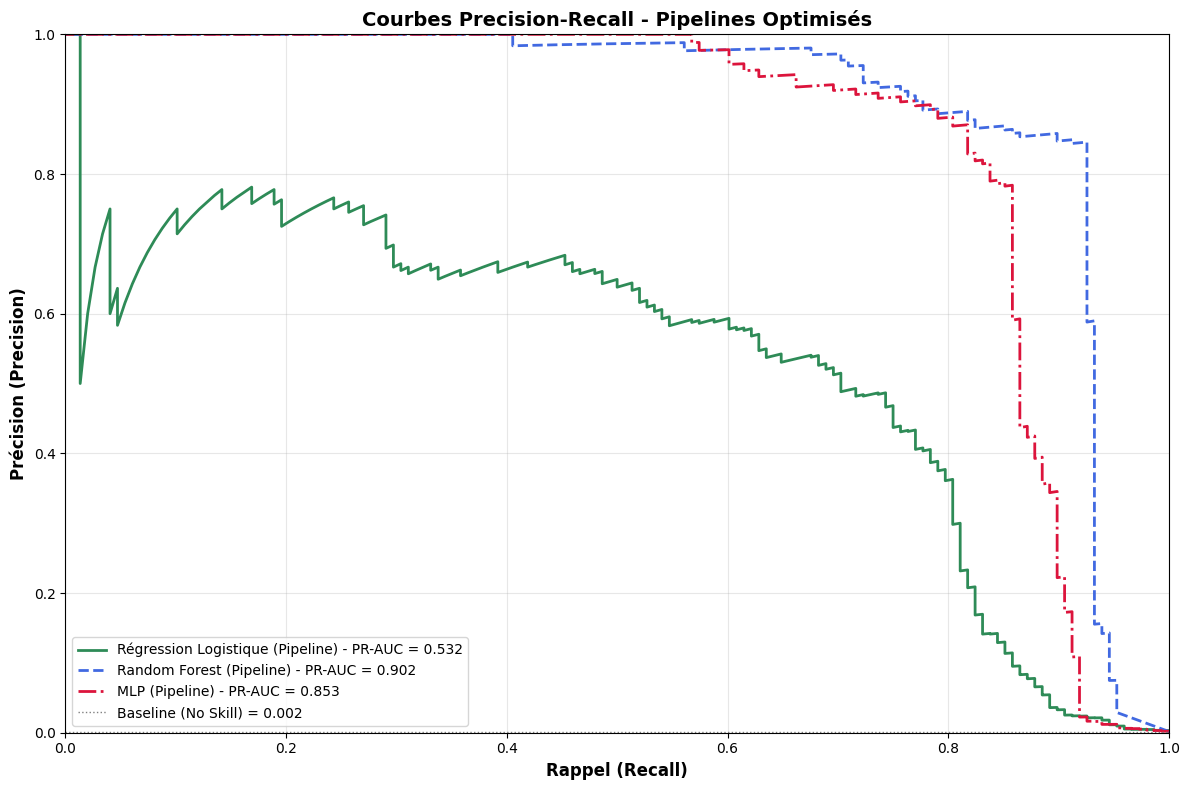

Interprétation des courbes PR (Pipelines Optimisés) :
• Plus la courbe est proche du coin supérieur droit, meilleur est le modèle
• Une courbe au-dessus de la ligne de base indique des performances supérieures au hasard
• Le PR-AUC résume la performance sur toute la courbe (plus élevé = meilleur)
Pipelines : Preprocessing cohérent et optimal pour chaque modèle
Prévention du data leakage : scaling basé uniquement sur les données d'entraînement


In [25]:
# Courbes Precision-Recall pour tous les pipelines optimisés
plt.figure(figsize=(12, 8))

colors = ['#2E8B57', '#4169E1', '#DC143C']
linestyles = ['-', '--', '-.']

for i, (name, pipeline) in enumerate(optimized_pipelines_aug.items()):
    # Prédictions de probabilité avec pipelines - preprocessing automatique
    y_pred_proba = pipeline.predict_proba(X_test)[:, 1]
    
    # Calcul de la courbe PR
    precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
    pr_auc = average_precision_score(y_test, y_pred_proba)
    
    # Affichage de la courbe
    plt.plot(recall, precision, color=colors[i], linestyle=linestyles[i], 
             linewidth=2, label=f'{name} (Pipeline) - PR-AUC = {pr_auc:.3f}')

# Ligne de référence (proportion de fraudes dans le dataset)
baseline = y_test.mean()
plt.axhline(y=baseline, color='gray', linestyle=':', linewidth=1, 
            label=f'Baseline (No Skill) = {baseline:.3f}')

plt.xlabel('Rappel (Recall)', fontsize=12, fontweight='bold')
plt.ylabel('Précision (Precision)', fontsize=12, fontweight='bold')
plt.title('Courbes Precision-Recall - Pipelines Optimisés', 
          fontsize=14, fontweight='bold')
plt.legend(loc='lower left', fontsize=10)
plt.grid(True, alpha=0.3)
plt.xlim([0, 1])
plt.ylim([0, 1])

plt.tight_layout()
plt.show()

print("Interprétation des courbes PR (Pipelines Optimisés) :")
print("• Plus la courbe est proche du coin supérieur droit, meilleur est le modèle")
print("• Une courbe au-dessus de la ligne de base indique des performances supérieures au hasard")
print("• Le PR-AUC résume la performance sur toute la courbe (plus élevé = meilleur)")
print("Pipelines : Preprocessing cohérent et optimal pour chaque modèle")
print("Prévention du data leakage : scaling basé uniquement sur les données d'entraînement")

MATRICES DE CONFUSION - MODÈLES OPTIMISÉS + SDV

Régression Logistique (Optimisé + SDV):
  Vrais Négatifs (TN) : 83,196 (légitimes bien classées)
  Faux Positifs (FP)  : 2,099 (légitimes classées comme fraudes)
  Faux Négatifs (FN)  : 17 (fraudes manquées)
  Vrais Positifs (TP) : 131 (fraudes détectées)
  Taux de fausses alertes : 2.461%
  Taux de fraudes manquées : 11.486%

Random Forest (Optimisé + SDV):
  Vrais Négatifs (TN) : 85,271 (légitimes bien classées)
  Faux Positifs (FP)  : 24 (légitimes classées comme fraudes)
  Faux Négatifs (FN)  : 14 (fraudes manquées)
  Vrais Positifs (TP) : 134 (fraudes détectées)
  Taux de fausses alertes : 0.028%
  Taux de fraudes manquées : 9.459%

MLP (Optimisé + SDV):
  Vrais Négatifs (TN) : 85,269 (légitimes bien classées)
  Faux Positifs (FP)  : 26 (légitimes classées comme fraudes)
  Faux Négatifs (FN)  : 26 (fraudes manquées)
  Vrais Positifs (TP) : 122 (fraudes détectées)
  Taux de fausses alertes : 0.030%
  Taux de fraudes manquées : 17.568

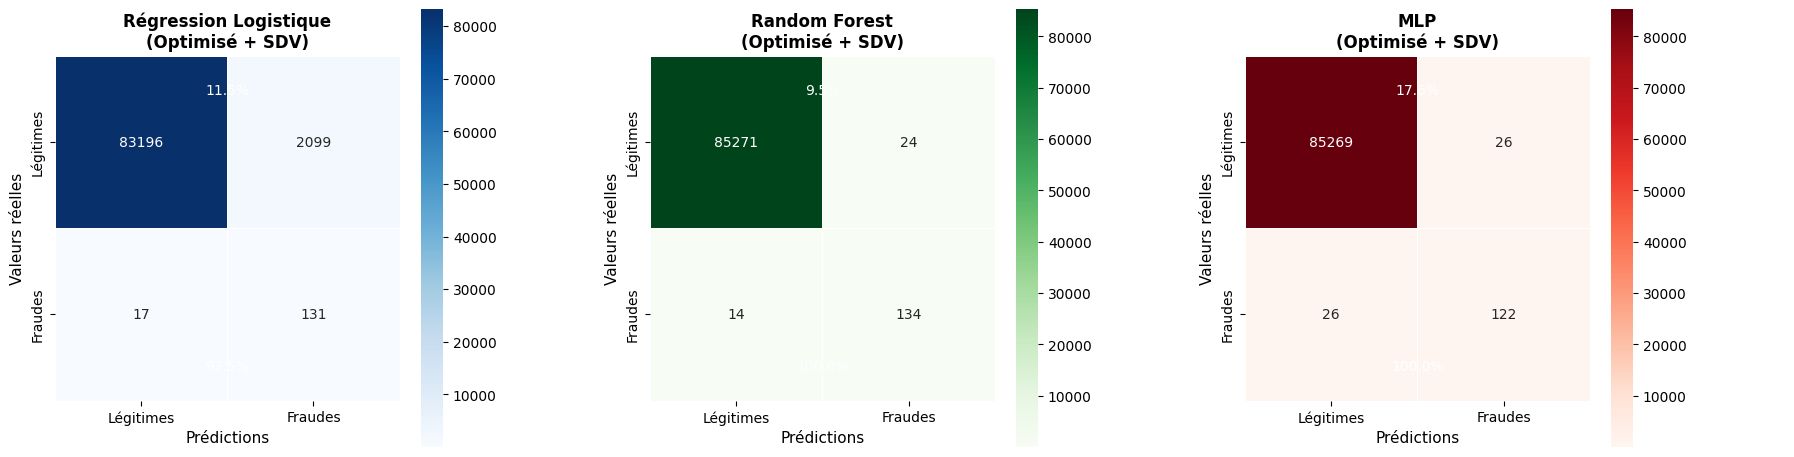


📊 INTERPRÉTATION DES MATRICES DE CONFUSION:
• Diagonal principale = prédictions correctes
• Faux Positifs (FP) = Fausses alertes (coût opérationnel)
• Faux Négatifs (FN) = Fraudes manquées (risque financier)
• Pour la fraude : minimiser FN est prioritaire sur minimiser FP


In [30]:
# Matrices de confusion pour les modèles optimisés avec SDV
from sklearn.metrics import confusion_matrix
import seaborn as sns

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

model_names = list(optimized_pipelines_aug.keys())
colors = ['Blues', 'Greens', 'Reds']

print("MATRICES DE CONFUSION - MODÈLES OPTIMISÉS + SDV")
print("=" * 55)

for i, (name, pipeline) in enumerate(optimized_pipelines_aug.items()):
    # Prédictions
    y_pred = pipeline.predict(X_test)
    
    # Matrice de confusion
    cm = confusion_matrix(y_test, y_pred)
    
    # Calcul des pourcentages pour l'affichage
    cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100
    
    # Affichage de la matrice avec pourcentages
    sns.heatmap(cm, annot=True, fmt='d', cmap=colors[i], ax=axes[i], 
                cbar=True, square=True, linewidths=0.5,
                xticklabels=['Légitimes', 'Fraudes'],
                yticklabels=['Légitimes', 'Fraudes'])
    
    axes[i].set_title(f'{name}\n(Optimisé + SDV)', fontsize=12, fontweight='bold')
    axes[i].set_xlabel('Prédictions', fontsize=11)
    axes[i].set_ylabel('Valeurs réelles', fontsize=11)
    
    # Calcul des métriques pour affichage
    tn, fp, fn, tp = cm.ravel()
    
    # Ajout des pourcentages comme texte
    axes[i].text(0.5, 0.1, f'{cm_percent[0,0]:.1f}%', ha='center', va='center', 
                fontsize=10, color='white', transform=axes[i].transAxes)
    axes[i].text(1.5, 0.1, f'{cm_percent[0,1]:.1f}%', ha='center', va='center', 
                fontsize=10, color='white', transform=axes[i].transAxes)
    axes[i].text(0.5, 0.9, f'{cm_percent[1,0]:.1f}%', ha='center', va='center', 
                fontsize=10, color='white', transform=axes[i].transAxes)
    axes[i].text(1.5, 0.9, f'{cm_percent[1,1]:.1f}%', ha='center', va='center', 
                fontsize=10, color='white', transform=axes[i].transAxes)
    
    print(f"\n{name} (Optimisé + SDV):")
    print(f"  Vrais Négatifs (TN) : {tn:,} (légitimes bien classées)")
    print(f"  Faux Positifs (FP)  : {fp:,} (légitimes classées comme fraudes)")
    print(f"  Faux Négatifs (FN)  : {fn:,} (fraudes manquées)")
    print(f"  Vrais Positifs (TP) : {tp:,} (fraudes détectées)")
    print(f"  Taux de fausses alertes : {fp/(fp+tn)*100:.3f}%")
    print(f"  Taux de fraudes manquées : {fn/(fn+tp)*100:.3f}%")

plt.tight_layout()
plt.show()

print(f"\n📊 INTERPRÉTATION DES MATRICES DE CONFUSION:")
print(f"• Diagonal principale = prédictions correctes")
print(f"• Faux Positifs (FP) = Fausses alertes (coût opérationnel)")
print(f"• Faux Négatifs (FN) = Fraudes manquées (risque financier)")
print(f"• Pour la fraude : minimiser FN est prioritaire sur minimiser FP")